# Tutorial 3: visualization of multi-omics networks

In this tutorial, we will use the built-in functions in iDDN package to visualize the common and differential networks. The visualization function of iDDN allows us to quickly make some simple plots, while it also allows the incorporation of multiple components and the customization of many details of the graph. We will use four examples in this tutorial.

In [1]:
from collections import Counter  # Find the degree of each node
import numpy as np
from IPython.display import Image
from iddn_data import load_data
from iddn import tools, visualize_multi  # visualize_multi is the main function for making plots

%load_ext autoreload
%autoreload 2

We will use the same example as the previous tutorial. But here we will run iDDN again with a larger panelty this time to make the graph sparser and easier to read. Recall that we have three omics type (mRNA + TF + miNRA), each with 50 nodes. We use the convenient `iddn_basic_pipeline` function. All we need for the visualization is the raw output of iDDN (`out_iddn`), as well as the names of all nodes (`node_names`).

In [2]:
example = load_data.load_example()

dat1 = example["dat1"]
dat2 = example["dat2"]
dep_mat = example["dep_mat"]
node_names = example['node_names']

res = tools.iddn_basic_pipeline(dat1, dat2, dep_mat, lambda1=0.3, lambda2=0.05)
out_iddn = res["out_iddn"]

Next we convert the iDDN output to common and differential network data frames, which are useful for drawing figures. This function was also used in the previous tutorial for us to save and share the iDDN results. `df_edge_comm` and `df_edge_diff` are Pandas dataframes that contain all edges in each graph. `nodes_comm` and `nodes_diff` give the lists of nodes that are present in the networks. Note that due to the usage of sparsity penalties, usually some nodes will not connect to any other node.

In [3]:
df_edge_comm, df_edge_diff, nodes_comm, nodes_diff = tools.iddn_output_to_csv(out_iddn, node_names)

We can take a look at the content of `df_edge_comm`

In [4]:
df_edge_comm

,gene1,gene2,condition,weight,color
0,mrna0,mrna1,0,-0.047618,blue
1,mrna0,mrna4,0,-0.016814,blue
2,mrna0,mrna43,0,-0.004087,blue
3,mrna0,mrna44,0,-0.034142,blue
4,mrna1,mrna2,0,-0.147875,blue
...,...,...,...,...,...
62,mrna46,tf36,0,0.020251,blue
63,mrna46,tf47,0,0.017000,blue
64,mrna48,tf29,0,-0.011418,blue
65,mrna48,mirna12,0,0.025847,blue


## Example 1: visualize the common network as a single layer
As a first example, we ignore the three omics types and draw all nodes in a single layer. For example, we want to draw all nodes around a large circle, and show the edges in the network. 

In this case, we need to specify the center and the radius of the circle. Here the center is at `[0, 0]`. As iDDN draws ellipse, what we need to specify is the length of the two axes, so for a circle we need the value is `[0.8, 0.8]`. Since iDDN allows drawing multiple objects, we need to make a $K\times 2$ array for center or radius, as shown in the code below. Details about the choice of these values will be discussed in the next section.

In [5]:
# Position and shape of each component
cen_lst = np.array([[0, 0]])
rad_lst = np.array([[0.8, 0.8]])

Next, we need to specify two lists: the first (`edge_mol0`) is the starting nodes of each edge, and the second list (`edge_mol1`) is the target nodes. Here we simply extract these information from the `df_edge_comm` dataframe.

In [6]:
# Prepare edges
edge_mol0 = []
edge_mol1 = []
for i in range(len(df_edge_comm)):
    mol0 = df_edge_comm.at[i, 'gene1']
    mol1 = df_edge_comm.at[i, 'gene2']
    edge_mol0.append(mol0)
    edge_mol1.append(mol1)


Now we have enough information to make the plot. We also need to provide the names of nodes to draw.
Here `fig_scale` controls the size of the figure, and more information will be given in the next section.

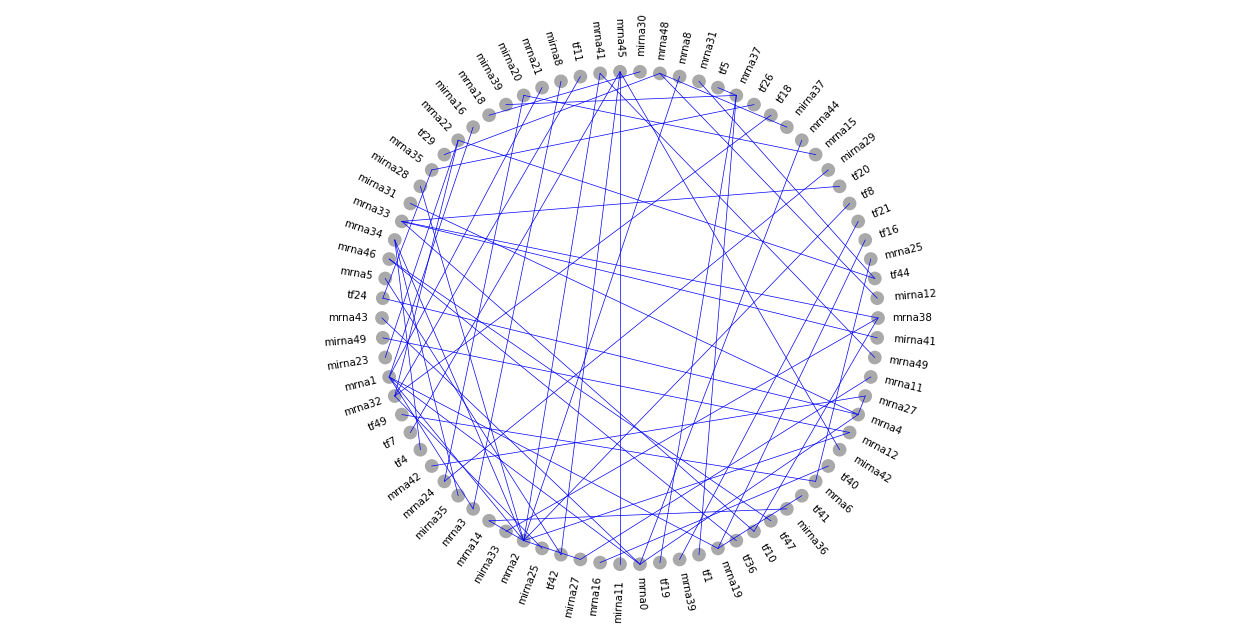

In [7]:
visualize_multi.draw_multi_layer_network(
    cen_lst=cen_lst,
    rad_lst=rad_lst,
    mol_name=nodes_comm,
    edge_mol0=edge_mol0,
    edge_mol1=edge_mol1,
    fig_scale=4,
)

We will see how to improve the above plots. For example, we can draw different omics types as different components, use different node size to represent degrees, and much more.

## Make graphs with multiple components

Before we can make some better looking plots of networks, we need to understand some basic of the iDDN plot function, which is illustrated in the figure below.
First, everything starts with a canvas of 4 inches by 2 inches (`fig_size` is defaulted as `[4,2]`), and we draw x-axis and y-axis cross the center of this canvas.
Then we can put components in this canvas. Each component will be used for a group of nodes in the network.
We currently support two types of components: ellipse and line. 

For ellipse, we can specify the shapes, and the nodes of the networks will be placed evenly on the boundary of the ellipse. For each ellipse, we first need to specify the position of the center on the canvas (`cen_lst` in the example above). For example, if we want to place the ellipse in the top-right corner of the canvas, it will be `[2, 1]`. If it is in the left-center, its position will be `[-1,0]`. Next, we need to specify the length of the horizontal axis and the vertical axis of each ellipse (`rad_lst` in the example above). For example, for group 3 below, the values will be `[0.5, 1]`, for group 2, it will be `[0.5, 0.5]`.

For line, we can have horizontal and vertical lines, and the nodes are placed evenly on the lines. For each line, we also need to specify the center of its position, which is the same as above. We also need to specify `rad_lst` for each line. For horizontal line, assume the length of the line is L, the value will be `[L/2, 0]`. For vertical line, it will be `[0, L/2]`. For example, the group 1 below will have `cen_lst` as `[-0.5, 0.1]`, and `rad_lst` as `[0, 0.8]`.

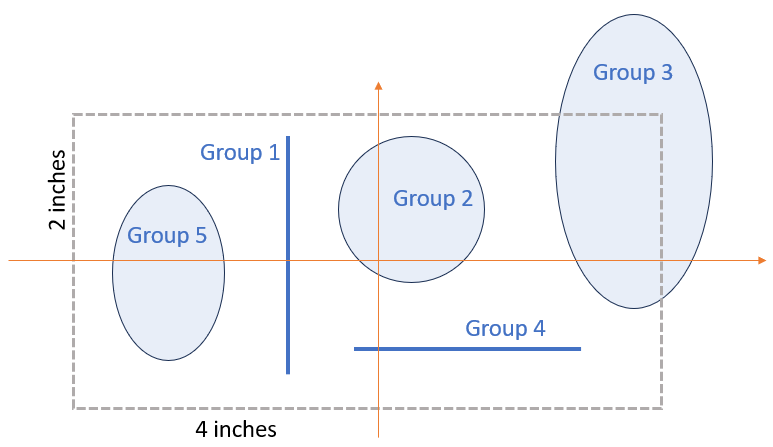

In [8]:
Image(filename=load_data.get_image_path("visualization_layout.png"))

If you like a larger canvas, set `fig_size` to desired values. For example, in the default canvas size of `[4,2]`, group 3 will be outside the canvas.
Then we can use `fig_scale` to globally enlarge the displayed and printed figure. Note that all the specifications of centers and radius should be with respect to `fig_size`.

## Example 2: visualize common network as two layers

Now we draw the common network with two components (groups). The first group is for TFs and miRNAs, and the second for mRNAs.
We use circles for both groups. We specify the center positions (`cen_lst`) and shapes (`rad_lst`) of the two components as follows.

In [9]:
# Position and shape of each component (for each group)
cen_lst = np.array([[-1, 0], [1, 0]])
rad_lst = np.array([[0.5, 0.8], [0.5, 0.8]])

We also plan to make size of each node in the network proportional to its degree (the number of edges incident with this node).
We use `Counter` to find the degree for each node, and calculate the largest degree. We use the `df_edge_common` data frame, as it will not include nodes that do not connect to any other node.

In [10]:
deg_comm_cnt = Counter(df_edge_comm['gene1'].to_list() + df_edge_comm['gene2'].to_list())
deg_comm_max = np.max(list(deg_comm_cnt.values()))

Then for each node, we specify which group it belong to (`mol_grp`), its name (`mol_name`), size (`mol_size`), and color (`mol_color`).
If the node name begins with `mrna`, it belong to group 1 (placed on the right); otherwise group 0 (placed on the left).
We scaled the degree of each node according to the maximum degree. For example, in the code below, if `deg_comm_max=10` and `deg=10`, then we specify the size as 2, which means twice the standard size, which is automatically determined.

In [11]:
# Prepare nodes
# Remove TFs with degree < 2
mol_grp = []
mol_name = []
mol_size = []
mol_color = []
for mol in nodes_comm:
    deg = deg_comm_cnt[mol]
    if mol.startswith("mrna"):
        mol_grp.append(1)
        mol_color.append("green")
    else:
        mol_grp.append(0)
        mol_color.append("orange")
    mol_size.append(deg/deg_comm_max*2)  # multiply by 2 enlarges the nodes
    mol_name.append(mol)
mol_grp = np.array(mol_grp)


We also specify the information for each edge. In addition to `edge_mol0` and `edge_mol1`, which were discussed before, we also specify the color of each edge `edge_color`, and its thickness `edge_weight`. Here we show edges with positive weight in blue, and those with negative weight in red. An edge with larger absolute weight will be thicker. 

In [12]:
# Prepare edges
edge_mol0 = []
edge_mol1 = []
edge_color = []
edge_weight = []
for i in range(len(df_edge_comm)):
    mol0 = df_edge_comm.at[i, 'gene1']
    mol1 = df_edge_comm.at[i, 'gene2']
    wt = df_edge_comm.at[i, 'weight']
    edge_mol0.append(mol0)
    edge_mol1.append(mol1)
    if wt<0:
        edge_color.append('red')
    else:
        edge_color.append('blue')
    edge_weight.append(np.abs(wt)*5)
    # edge_weight.append(0.25)


Now we can draw the figure. Here we enlarge the canvas (`fig_size`) to make it a bit taller to accommodate the labels.
If you want to save the figure, you may specify `out_name` as the file name, like `common_network.png`.

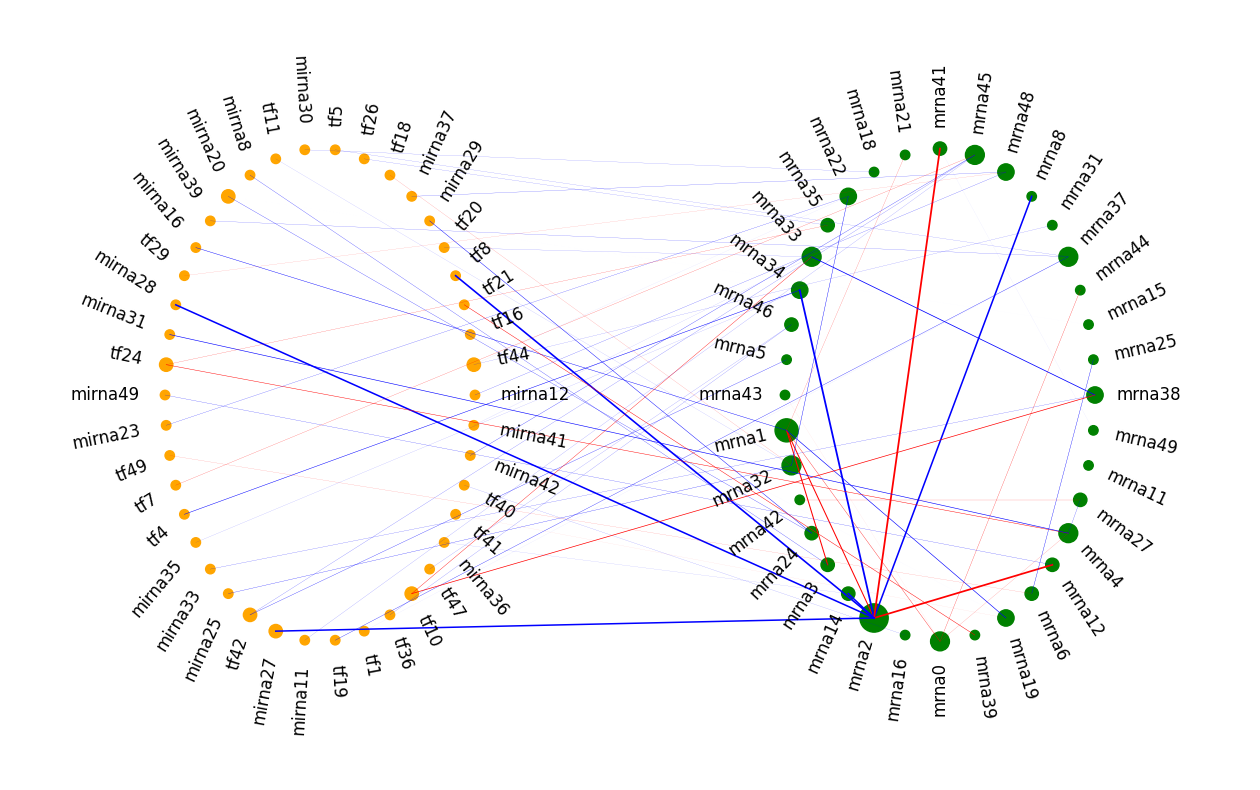

In [13]:
out_name = ""
visualize_multi.draw_multi_layer_network(
    cen_lst=cen_lst,
    rad_lst=rad_lst,
    mol_name=mol_name,
    mol_grp=mol_grp,
    mol_size=mol_size,
    mol_color=mol_color,
    edge_mol0=edge_mol0,
    edge_mol1=edge_mol1,
    edge_color=edge_color,
    edge_weight=edge_weight,
    fig_size=np.array((4, 2.5)),
    fig_scale=4,
    font_size_scale=1.5,
    out_name=out_name,
)

As we can see, node `mrna2` is a hub in the common network. Its node size is large, which means it connects with more edges. Those edges are also thicker than others due to the large weights. By the way, in the simulation, node `mran2` is the hub in the scale-free graph in the mRNA layer.

## Example 3: visualize differential network as three layers

We can include as many components as we like. For this example, since we have three omics types, it is natural to use three components.
Besides, we will draw the differential network this time. 

The code is very similar to the one above. Note several differences: 1) there are three circles now in `cen_lst` and `rad_lst`, 2) there are three groups in `mol_grp`, and 3) we color the differential edges according to whether it occurs in condition 1 (blue) or condition 2 (red).

In [14]:
deg_diff_cnt = Counter(df_edge_diff['gene1'].to_list() + df_edge_diff['gene2'].to_list())
deg_diff_max = np.max(list(deg_diff_cnt.values()))

# Position and shape of each component (for each group)
cen_lst = np.array([[-1, 1], [1, 0.6], [0, -0.9]])
rad_lst = np.array([[0.4, 0.6], [0.4, 0.6], [0.4, 0.4]])

# Prepare nodes
# Remove TFs with degree < 2
mol_grp = []
mol_name = []
mol_size = []
mol_color = []
for mol in nodes_diff:
    deg = deg_diff_cnt[mol]
    if mol.startswith("mrna"):
        mol_grp.append(1)
        mol_color.append("green")
    elif mol.startswith("tf"):
        mol_grp.append(0)
        mol_color.append("orange")
    else:
        mol_grp.append(2)
        mol_color.append("orange")        
    mol_size.append(deg/deg_comm_max)
    mol_name.append(mol)
mol_grp = np.array(mol_grp)

# Prepare edges
edge_mol0 = []
edge_mol1 = []
edge_color = []
edge_weight = []
for i in range(len(df_edge_diff)):
    mol0 = df_edge_diff.at[i, 'gene1']
    mol1 = df_edge_diff.at[i, 'gene2']
    cond = df_edge_diff.at[i, 'condition']
    wt = df_edge_diff.at[i, 'weight']
    edge_mol0.append(mol0)
    edge_mol1.append(mol1)
    if cond==0:
        edge_color.append('blue')
    else:
        edge_color.append('red')
    edge_weight.append(np.abs(wt)*5)

We further enlarges the canvas height (`fig_size`) as this time the plot is closer to a square.

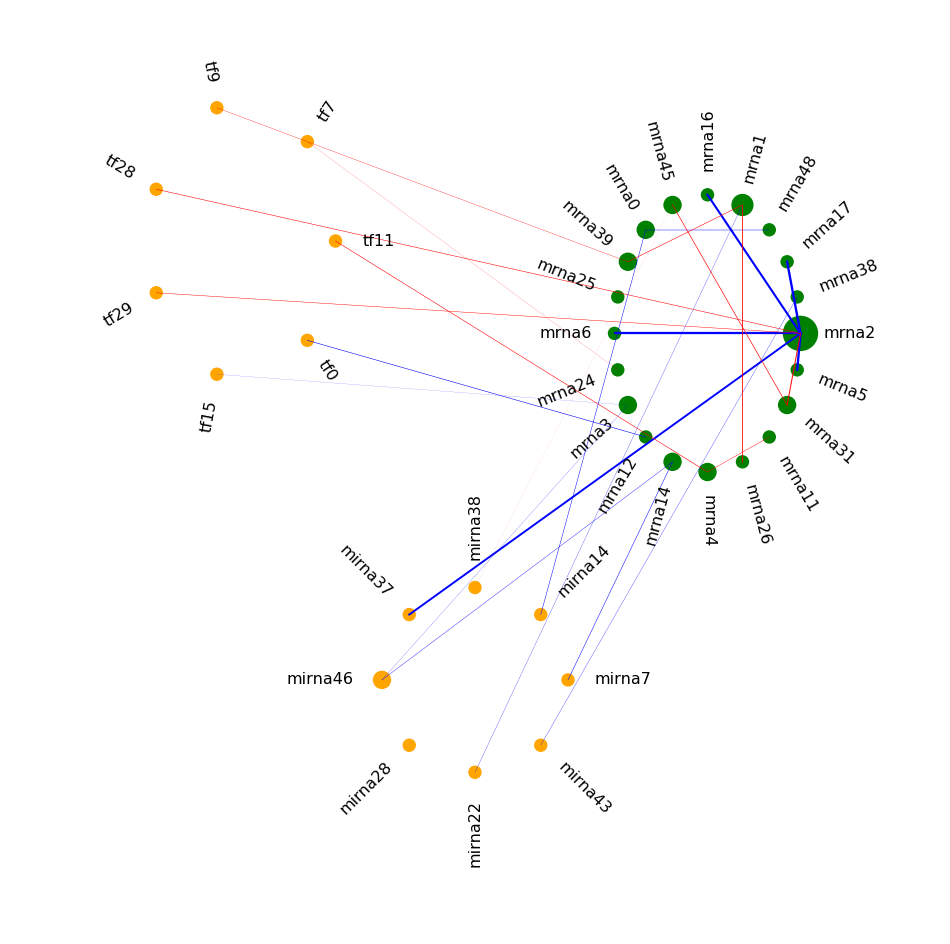

In [15]:
out_name = ""
visualize_multi.draw_multi_layer_network(
    cen_lst=cen_lst,
    rad_lst=rad_lst,
    mol_name=mol_name,
    mol_grp=mol_grp,
    mol_size=mol_size,
    mol_color=mol_color,
    edge_mol0=edge_mol0,
    edge_mol1=edge_mol1,
    edge_color=edge_color,
    edge_weight=edge_weight,
    fig_size=np.array((4, 4)),
    fig_scale=3,
    font_size_scale=0.8,
    out_name=out_name,
)

It is clear that node `mrna2` is a hub in the differential network (rewiring).

## Example 4: use a line instead of a circle

As a final example, we will use a line for the TF and miRNA nodes in the common network.
This is a reasonable choice, as there are no edges among TFs and miRNAs in this example.
The code is similar to example 2. The main difference is that now for the first component, the `rad_lst` value is `[0,1]`.

In [16]:
deg_comm_cnt = Counter(df_edge_comm['gene1'].to_list() + df_edge_comm['gene2'].to_list())
deg_comm_max = np.max(list(deg_comm_cnt.values()))

# Position and shape of each component (for each group)
cen_lst = np.array([[1, 0], [-1, 0]])
rad_lst = np.array([[0, 1], [0.5, 0.8]])

# Prepare nodes
# Remove TFs with degree < 2
mol_grp = []
mol_name = []
mol_size = []
mol_color = []
for mol in nodes_comm:
    deg = deg_comm_cnt[mol]
    if mol.startswith("mrna"):
        mol_grp.append(1)
        mol_color.append("green")
    else:
        mol_grp.append(0)
        mol_color.append("orange")
    mol_size.append(deg/deg_comm_max*2)
    mol_name.append(mol)
mol_grp = np.array(mol_grp)

# Prepare edges
edge_mol0 = []
edge_mol1 = []
edge_color = []
edge_weight = []
for i in range(len(df_edge_comm)):
    mol0 = df_edge_comm.at[i, 'gene1']
    mol1 = df_edge_comm.at[i, 'gene2']
    wt = df_edge_comm.at[i, 'weight']
    edge_mol0.append(mol0)
    edge_mol1.append(mol1)
    if wt<0:
        edge_color.append('red')
    else:
        edge_color.append('blue')
    edge_weight.append(np.abs(wt)*5)

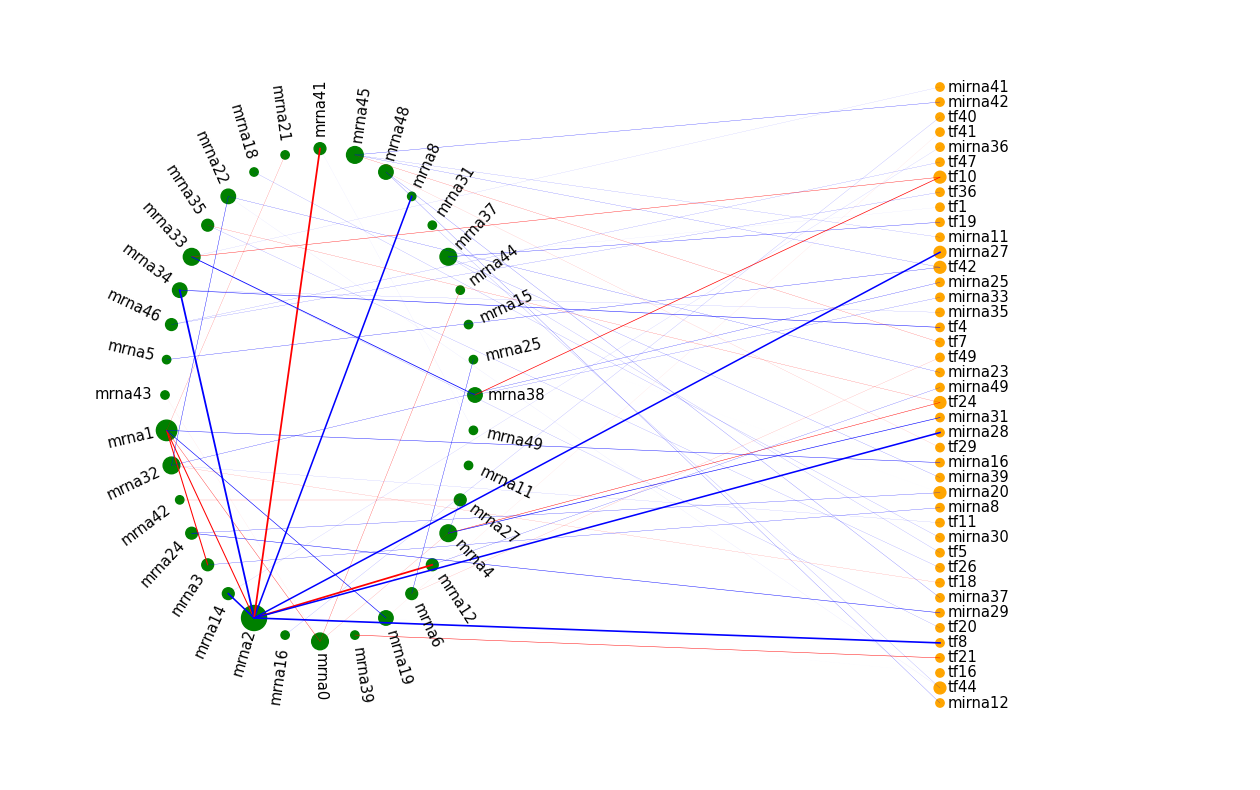

In [17]:
out_name = ""
visualize_multi.draw_multi_layer_network(
    cen_lst=cen_lst,
    rad_lst=rad_lst,
    mol_name=mol_name,
    mol_grp=mol_grp,
    mol_size=mol_size,
    mol_color=mol_color,
    edge_mol0=edge_mol0,
    edge_mol1=edge_mol1,
    edge_color=edge_color,
    edge_weight=edge_weight,
    fig_size=np.array((4, 2.5)),
    fig_scale=4,
    font_size_scale=1.5,
    out_name=out_name,
)

The illustration above might be easier to read than example 2.

## Next steps

There are some more functions in the visualization module in iDDN. For example, we can specify a label for each node, so that we will print `mol_label` in the graph, instead of `mol_name`. You may wish to read the documentation of `draw_multi_layer_network` and the code to better understand its functionality.

The visualization function of iDDN is simple yet flexible for many of the tasks. For some more sophisticated cases, network visualization tools like Cytoscape may be a better choice.

The next tutorial will talk about the parameter tuning functions of iDDN.